In [1]:
from torchsummary                 import summary
from tqdm                         import tqdm
from src.data.to_tensor           import ToTensor
from src.data.mrw_dataset         import MRWDataset
from src.data.create_data_loaders import create_data_loaders
from src.nn.archs                 import CNN_ALL, CNN_ALL_VDCNNFRW_M18, Wav2Vec2ALL
from src.nn.results.utils         import (get_all_predictions, analyse_predictions, 
                                            plot_distributions, plot_losses, get_MSEs, plot_correlation)

import random
import torch
import torch.nn           as nn
import numpy              as np
import src.ctes.num_ctes  as nctes
import src.ctes.str_ctes  as sctes
import src.ctes.path_ctes as pctes

In [2]:
builder = CNN_ALL_VDCNNFRW_M18

In [3]:
data_path = pctes.DATAPATH
timestamp = "2024_02_08__09_32_10"
arch_name = builder.__name__
hyperparams_path = f"../../../data/models/hyperparams_{arch_name}_{timestamp}.npz"
model_path = f"../../../data/models/model_{arch_name}_{timestamp}.pt"
losses_path = f"../../../data/models/losses_{arch_name}_{timestamp}.npz"
losses_img_path = f"../../../data/models/losses_{arch_name}_{timestamp}.png"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [5]:
hyperparams = np.load(hyperparams_path)
print(hyperparams)

NpzFile '../../../data/models/hyperparams_CNN_ALL_VDCNNFRW_M18_2024_02_08__09_32_10.npz' with keys: len, test_size, valid_size, epochs, batch_size...


In [6]:
seed = int(hyperparams[sctes.SEED])
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [7]:
sample_size = nctes.LEN_SAMPLE
model = builder(input_size=sample_size, dropout_probs=hyperparams[sctes.DROPOUT_PROBS])
model.to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
# summary(model, (1, sample_size))

<All keys matched successfully>

In [8]:
transform = ToTensor()

data      = MRWDataset(data_path, transform, sample_size, builder.LABELS)

In [9]:
batch_size = int(hyperparams[sctes.BATCH_SIZE])
valid_size = float(hyperparams[sctes.VALID_SIZE])
test_size = float(hyperparams[sctes.TEST_SIZE])

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [10]:
losses = np.load(losses_path)
train_losses = losses[sctes.TRAIN]
valid_losses = losses[sctes.VAL]

In [11]:
criterion = nn.MSELoss()
print(f"{criterion = }")

criterion = MSELoss()


In [12]:
data_len = int(hyperparams[sctes.LEN])
test_len = int(hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])
valid_len = int((hyperparams[sctes.LEN] - hyperparams[sctes.LEN]*hyperparams[sctes.TEST_SIZE])*hyperparams[sctes.VALID_SIZE])
train_len = data_len - test_len - valid_len

if sctes.MODEL_NAME in hyperparams :
    print(f"Model name       = {hyperparams[sctes.MODEL_NAME]}")
print(f"Sample length    = {nctes.LEN_SAMPLE}")
print(f"Total samples    = {data_len}")
print(f"Train samples    = {train_len}")
print(f"Valid samples    = {valid_len}")
print(f"Test samples     = {test_len}")
print(f"Batch size       = {int(hyperparams[sctes.BATCH_SIZE])}")
print(f"Number of epochs = {int(hyperparams[sctes.EPOCHS])}")
print(f"Loss             = {''.join(hyperparams[sctes.CRITERION].tolist())}")
print(f"Optimizer        = {''.join(hyperparams[sctes.OPTIMIZER].tolist())}")
# print(f"Learning rate    = {float(hyperparams[sctes.LR])}")
print(f"Seed             = {float(hyperparams[sctes.SEED])}")
if sctes.DROPOUT_PROBS in hyperparams:
    print(f"Dropout probas    = {hyperparams[sctes.DROPOUT_PROBS].tolist()}")
print(f"Labels           = {builder.LABELS}")

Model name       = Top-Down v2
Sample length    = 32768
Total samples    = 12800
Train samples    = 8192
Valid samples    = 2048
Test samples     = 2560
Batch size       = 6
Number of epochs = 250
Loss             = MSELoss()
Optimizer        = Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)
Seed             = 42.0
Dropout probas    = []
Labels           = ['c1', 'c2', 'L', 'EPSILON']


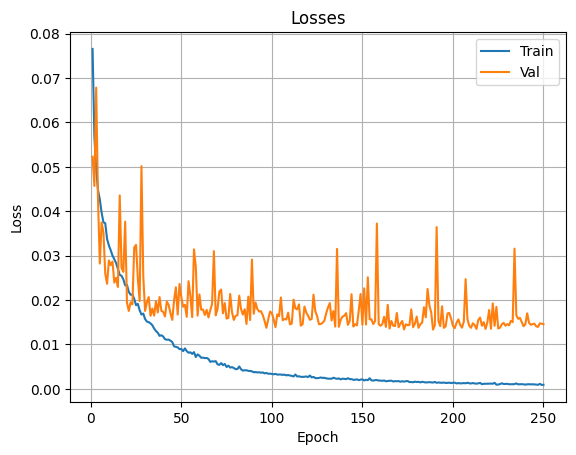

In [13]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])
# plt.savefig(losses_img_path)

In [14]:
targets, preds, output_losses  = get_all_predictions(model, test_loader, device, criterion, builder.LABELS)

  0%|          | 0/427 [00:00<?, ?it/s]

100%|██████████| 427/427 [00:02<00:00, 165.06it/s]


In [15]:
preds.shape

(2560, 4)

In [16]:
analyse_predictions(targets, preds)

True values of c1 and their count : 
0.0: 665 occurrences
0.3333333432674408: 625 occurrences
0.6666666865348816: 635 occurrences
1.0: 635 occurrences

Predicted values of c1 and their count: 
0.00027512124506756663: 1 occurrences
0.0004537141358014196: 1 occurrences
0.0007157284999266267: 1 occurrences
0.0011233832919970155: 1 occurrences
0.0011541714193299413: 1 occurrences
0.0015057242708280683: 1 occurrences
0.0015723733231425285: 1 occurrences
0.001640196656808257: 1 occurrences
0.0016778894932940602: 1 occurrences
0.0017136745154857635: 1 occurrences
0.0017186930635944009: 1 occurrences
0.0017271050019189715: 1 occurrences
0.0018542581237852573: 1 occurrences
0.0019027580274268985: 1 occurrences
0.00195431150496006: 1 occurrences
0.0020073975902050734: 1 occurrences
0.002025957452133298: 1 occurrences
0.0020704534836113453: 1 occurrences
0.002147952327504754: 1 occurrences
0.002194750588387251: 1 occurrences
0.0022591128945350647: 1 occurrences
0.002281680004671216: 1 occurrences

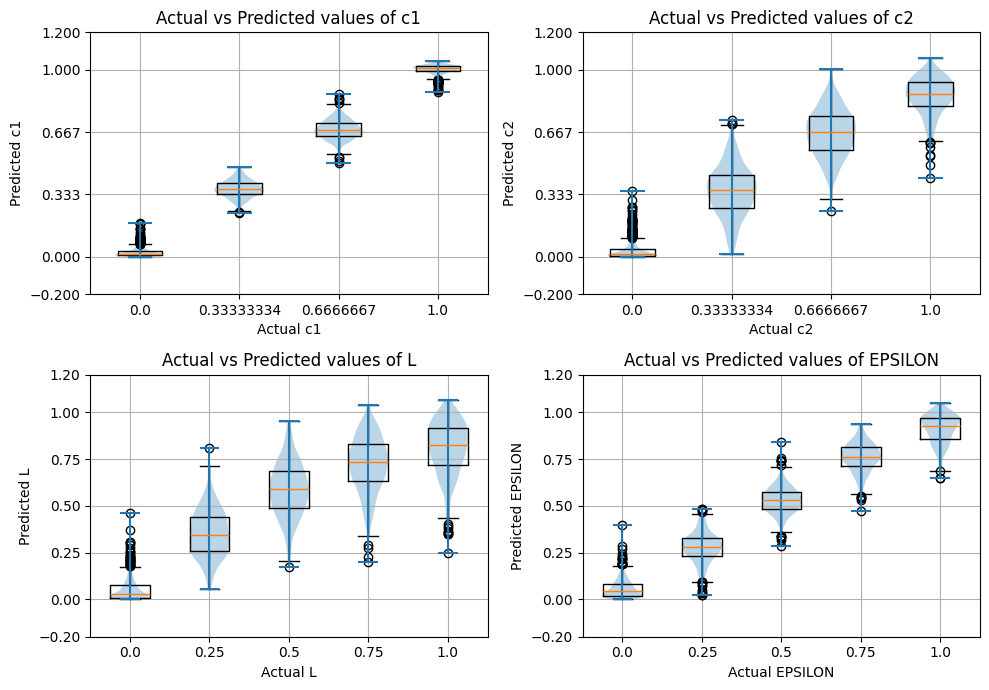

In [17]:
plot_distributions(targets, preds, builder.LABELS)

In [18]:
preds.shape

(2560, 4)

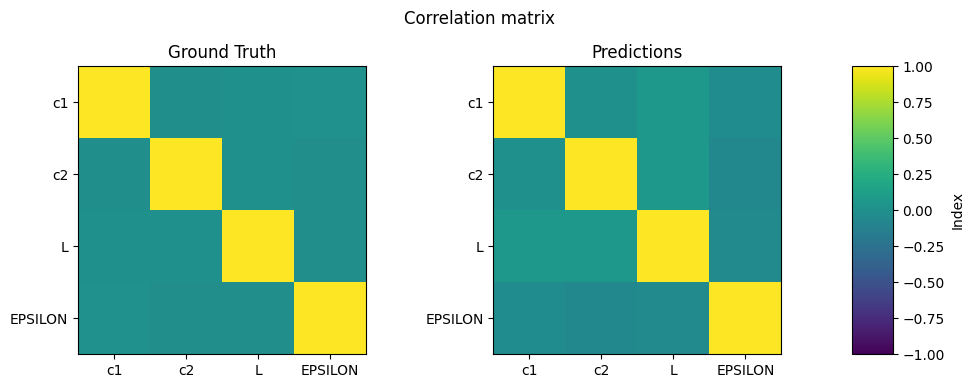

In [19]:
plot_correlation(targets, preds, builder.LABELS)

In [20]:
total_test_loss, mean_output_losses = get_MSEs(targets, preds, output_losses, builder.LABELS, device, criterion)
print("Total Test MSE = {:0.4f}".format(total_test_loss))
print("")
print("Test MSE for each output:")
for key, value in mean_output_losses.items():
    print(f"{key}: {value:.4f}")

Total Test MSE = 0.0138

Test MSE for each output:
c1: 0.0019
c2: 0.0167
L: 0.0286
EPSILON: 0.0080


In [21]:
n_show = 10
print(f"{n_show} Worst Results ==>")
for i in range(n_show):
    print(f"              c1         c2         L         epsilon")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[i]]}")
    print(f"MSE         = {['{:0.4f}'.format(output_losses[p][i]) for p in range(len(builder.LABELS))]}")
    print()

10 Worst Results ==>
              c1         c2         L         epsilon
Target      = ['0.6667', '0.3333', '0.2500', '0.2500']
Prediction  = ['0.6700', '0.5576', '0.1840', '0.3041']
MSE         = ['0.0018', '0.0125', '0.0104', '0.0081']

              c1         c2         L         epsilon
Target      = ['1.0000', '0.0000', '0.0000', '0.2500']
Prediction  = ['1.0135', '0.1324', '0.0003', '0.0687']
MSE         = ['0.0018', '0.0282', '0.0131', '0.0029']

              c1         c2         L         epsilon
Target      = ['0.3333', '1.0000', '0.7500', '0.0000']
Prediction  = ['0.3799', '0.9779', '0.5331', '0.0444']
MSE         = ['0.0014', '0.0287', '0.0180', '0.0057']

              c1         c2         L         epsilon
Target      = ['0.0000', '0.3333', '0.7500', '1.0000']
Prediction  = ['0.0233', '0.3212', '0.6490', '0.9831']
MSE         = ['0.0039', '0.0303', '0.0131', '0.0102']

              c1         c2         L         epsilon
Target      = ['0.6667', '0.3333', '0.5000', 

In [22]:
n_show = 10
print(f"{n_show} Best Results ==>")
for i in range(n_show, 0, -1):
    print(f"              {[label + '    ' for label in builder.LABELS]}")
    print(f"Target      = {['{:0.4f}'.format(f) for f in targets[-i]]}")
    print(f"Prediction  = {['{:0.4f}'.format(f) for f in preds[-i]]}")
    print(f"MSE         = {['{:0.4f}'.format(output_losses[p][-i]) for p in range(len(builder.LABELS))]}")
    print()

10 Best Results ==>
              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['1.0000', '1.0000', '0.2500', '0.2500']
Prediction  = ['0.9906', '0.8731', '0.3302', '0.3856']
MSE         = ['0.0007', '0.0089', '0.0459', '0.0029']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.0000', '0.5000', '0.0000']
Prediction  = ['0.3848', '0.0591', '0.5408', '0.0285']
MSE         = ['0.0013', '0.0414', '0.0222', '0.0014']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.6667', '0.0000', '1.0000']
Prediction  = ['0.3544', '0.5357', '0.0219', '1.0372']
MSE         = ['0.0030', '0.0165', '0.0120', '0.0137']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.3333', '0.3333', '0.2500', '0.0000']
Prediction  = ['0.2971', '0.4627', '0.3037', '0.0292']
MSE         = ['0.0010', '0.0210', '0.0071', '0.0018']

              ['c1    ', 'c2    ', 'L    ', 'EPSILON    ']
Target      = ['0.000